## All you need is love… And a pet!

<img src="img/dataset-cover.jpg" width="920">

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import seaborn as sn
%matplotlib inline

data_folder = './data/'

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

The use of external libraries is not permitted in part A, except for numpy and pandas. 
You can drop entries with missing values.

In [3]:
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']
original_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv', usecols=columns)
original_data.dropna(inplace=True)
original_data.head(10)

,outcome_type,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days
0,Return to Owner,Neutered Male,10.0,Dog,Normal,Stray,Neutered Male,10.0,2017,1.0,0.588194
1,Return to Owner,Neutered Male,7.0,Dog,Normal,Public Assist,Neutered Male,7.0,2014,2.0,1.259722
2,Return to Owner,Neutered Male,6.0,Dog,Normal,Public Assist,Neutered Male,6.0,2014,3.0,1.113889
3,Transfer,Neutered Male,10.0,Dog,Normal,Owner Surrender,Neutered Male,10.0,2014,1.0,4.970139
4,Return to Owner,Neutered Male,16.0,Dog,Injured,Public Assist,Neutered Male,16.0,2013,1.0,0.119444
5,Return to Owner,Spayed Female,15.0,Dog,Aged,Stray,Spayed Female,15.0,2013,1.0,0.870833
6,Return to Owner,Intact Female,15.0,Dog,Normal,Stray,Intact Female,15.0,2014,1.0,0.178472
7,Return to Owner,Neutered Male,15.0,Dog,Normal,Stray,Neutered Male,15.0,2014,1.0,0.213194
8,Return to Owner,Neutered Male,15.0,Dog,Normal,Public Assist,Neutered Male,15.0,2014,1.0,6.258333
9,Return to Owner,Spayed Female,18.0,Dog,Normal,Stray,Spayed Female,18.0,2015,1.0,0.054167


In [4]:
df = original_data.copy()

df['adopted'] = df.outcome_type.apply(lambda r : 1 if r == 'Adoption' else 0)
df.drop("outcome_type", axis=1, inplace=True)
df.head()

## Feature = input, label = output or what we are trying to predict. In this case it's whether
## or not the animal ends up being adopted. We convert the adoption into a binary value and drop
## the original one. All of the other columns represent the set's features

,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,adopted
0,Neutered Male,10.0,Dog,Normal,Stray,Neutered Male,10.0,2017,1.0,0.588194,0
1,Neutered Male,7.0,Dog,Normal,Public Assist,Neutered Male,7.0,2014,2.0,1.259722,0
2,Neutered Male,6.0,Dog,Normal,Public Assist,Neutered Male,6.0,2014,3.0,1.113889,0
3,Neutered Male,10.0,Dog,Normal,Owner Surrender,Neutered Male,10.0,2014,1.0,4.970139,0
4,Neutered Male,16.0,Dog,Injured,Public Assist,Neutered Male,16.0,2013,1.0,0.119444,0


In [5]:
## We can now perform the triage into the training and testing data sets. 
## It is generally recommended to do this before trying to binarise the categorical data(c.f. gpt)

def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]
## np.random.rand is used to generate an array the size of the dataframe of random numbers between 0 and 1
##if it is below the ratio, then its true, else it's false
## .random is the module, .rand is the fucntion that defines the random number between 0 and 1
## Then defined into an array

[train, test] = split_set(df, ratio = 0.8)

In [6]:
## Categorical columns are then created on the training dataset
## The ones in the test dataset are made to match it
## .getdummies is applied to each categorical column of the dataframe. 
## The function runs through each and every possible outcome to it and seperates these into new binary columns. 

categorical_columns = ['sex_upon_outcome', 'animal_type', 'intake_condition',
                       'intake_type', 'sex_upon_intake']
train_categorical = pd.get_dummies(train, columns=categorical_columns)
test_categorical = pd.get_dummies(test, columns=categorical_columns)[train_categorical.columns]

if train_categorical.columns.equals(test_categorical.columns):
    print("True") ## verification

## The adopted column must now be dropped from the train and test categorical but be inserted into the label
train_label = train_categorical['adopted']
test_label = test_categorical['adopted']
train_features = train_categorical.drop("adopted", axis=1)
test_features = test_categorical.drop("adopted", axis=1)

#test_features.head(10)
#train_label.head(10)

True


In [7]:
train_categorical.head(10)

,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,adopted,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,...,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
0,6.0,6.0,2014,3.0,1.113889,0,False,False,True,False,...,False,False,True,False,False,False,False,True,False,False
1,10.0,10.0,2014,1.0,4.970139,0,False,False,True,False,...,False,True,False,False,False,False,False,True,False,False
2,15.0,15.0,2013,1.0,0.870833,0,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
3,15.0,15.0,2014,1.0,0.213194,0,False,False,True,False,...,False,False,False,True,False,False,False,True,False,False
4,15.0,15.0,2014,1.0,6.258333,0,False,False,True,False,...,False,False,True,False,False,False,False,True,False,False
5,18.0,18.0,2015,1.0,0.054167,0,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
6,14.0,14.0,2014,1.0,14.120139,0,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
7,17.0,17.0,2016,1.0,9.020139,1,False,False,True,False,...,False,False,True,False,False,False,False,True,False,False
8,13.0,13.0,2013,1.0,10.886111,0,True,False,False,False,...,False,False,False,True,False,True,False,False,False,False
9,19.0,19.0,2013,1.0,0.067361,0,False,False,False,True,...,True,False,False,False,False,False,False,False,True,False


In [8]:
## We may now standardise everything as described in the promptn, even for categorical values
means = train_features.mean()
stddevs = train_features.std() ## Means and standard deviations are returned

train_features_std = pd.DataFrame()
for c in train_features.columns:
    train_features_std[c] = (train_features[c]-means[c])/stddevs[c] 

test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c]-means[c])/stddevs[c] ## means and std of the training set are used

train_features_std.head()

,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,...,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
0,1.339259,1.354102,-1.103882,4.087898,-0.373469,-0.363107,-0.37216,1.340334,-0.685317,-0.304187,...,-0.055985,-0.482076,3.876850,-1.536838,-0.212915,-0.650921,-0.68497,2.292218,-0.400880,-0.304187
1,2.724045,2.741943,-1.103882,-0.275852,-0.280874,-0.363107,-0.37216,1.340334,-0.685317,-0.304187,...,-0.055985,2.074330,-0.257937,-1.536838,-0.212915,-0.650921,-0.68497,2.292218,-0.400880,-0.304187
2,4.455027,4.476746,-1.871628,-0.275852,-0.379305,-0.363107,-0.37216,-0.746071,1.459156,-0.304187,...,-0.055985,-0.482076,-0.257937,0.650676,-0.212915,-0.650921,-0.68497,-0.436252,2.494474,-0.304187
3,4.455027,4.476746,-1.103882,-0.275852,-0.395096,-0.363107,-0.37216,1.340334,-0.685317,-0.304187,...,-0.055985,-0.482076,-0.257937,0.650676,-0.212915,-0.650921,-0.68497,2.292218,-0.400880,-0.304187
4,4.455027,4.476746,-1.103882,-0.275852,-0.249942,-0.363107,-0.37216,1.340334,-0.685317,-0.304187,...,-0.055985,-0.482076,3.876850,-1.536838,-0.212915,-0.650921,-0.68497,2.292218,-0.400880,-0.304187


### B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. 
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. 

In [9]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int) ## probabilities are converted into binary predictions   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1)) ## adds one if both conditions are met
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]]) ## defines the matrix 
    return confusion_matrix
## prediction proba is the list of probabilities given by the logistic regression
## true label is the list of actual class labels for the dataset

def plot_confusion_matrix(confusion_matrix):## very visual way to represent the confusion matrix 
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]]) ## adds labels to each of the entries in the confusin matrix 
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) ## converts confusion matrix into a pd df
    
    return sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')


def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) 
    precision_negative = TN/(TN+FN) 
    
    recall_positive = TP/(TP+FN) 
    recall_negative = TN/(TN+FP) 

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [10]:
## the functions are initially defined
## The model may now be created

logistic = LogisticRegression(solver='lbfgs', max_iter=1000)
logistic.fit(train_features_std, train_label)
prediction_proba = logistic.predict_proba(test_features_std)

In [11]:
## And its performance represented

confusion_matrix05 = compute_confusion_matrix(test_label, prediction_proba, decision_threshold=0.5)

plt.figure(figsize = (4,3)) 
ax = plot_confusion_matrix(confusion_matrix1)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for a 0.5 threshold')
plt.show

NameError: name 'confusion_matrix1' is not defined

<Figure size 400x300 with 0 Axes>

In [ ]:
[t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(confusion_matrix05)

print(t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative)

0.5 0.8219597829556335 0.7713256484149856 0.8166285278413424 0.7933308632826973 0.8622349570200573 0.8257958287596048 0.8436220913933277


### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

In [ ]:
threshold = []
t=0
while t<=1 :
    threshold.append(t)
    t+=0.1

threshold = [round(t,1) for t in threshold]

print(threshold)



[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [ ]:
for dt in threshold:
    confusion_matrix = compute_confusion_matrix(test_label, prediction_proba, dt)
    [t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(confusion_matrix)
    print("For threshold of {}: t = {}, accuracy = {}, precision_positive = {}, recall_positive = {}, F1_score_positive = {}, \
        precision_negative = {}, recall_negative = {}, F1_score_negative = {}"\
        .format(dt, t, accuracy, precision_positive, recall_positive, F1_score_positive, \
        precision_negative, recall_negative, F1_score_negative))

For threshold of 0: t = 0.5, accuracy = 0.4184487711458666, precision_positive = 0.4184487711458666, recall_positive = 1.0, F1_score_positive = 0.59000900090009,         precision_negative = nan, recall_negative = 0.0, F1_score_negative = nan
For threshold of 0.1: t = 0.5, accuracy = 0.7172677944462177, precision_positive = 0.6001318764129616, recall_positive = 0.9719298245614035, F1_score_positive = 0.7420651097781142,         precision_negative = 0.9635571400277283, recall_negative = 0.5340285400658616, F1_score_negative = 0.6871954234056077
For threshold of 0.2: t = 0.5, accuracy = 0.7603574848388126, precision_positive = 0.6456881306564027, recall_positive = 0.9469107551487415, F1_score_positive = 0.7678129638792678,         precision_negative = 0.9424983476536682, recall_negative = 0.6261251372118551, F1_score_negative = 0.7524073341247857
For threshold of 0.3: t = 0.5, accuracy = 0.7931056495371848, precision_positive = 0.6902411021814007, recall_positive = 0.917162471395881, F1_

### D) Plot in a bar chart the coefficients of the logistic regression sorted by their contribution to the prediction.

<BarContainer object of 32 artists>

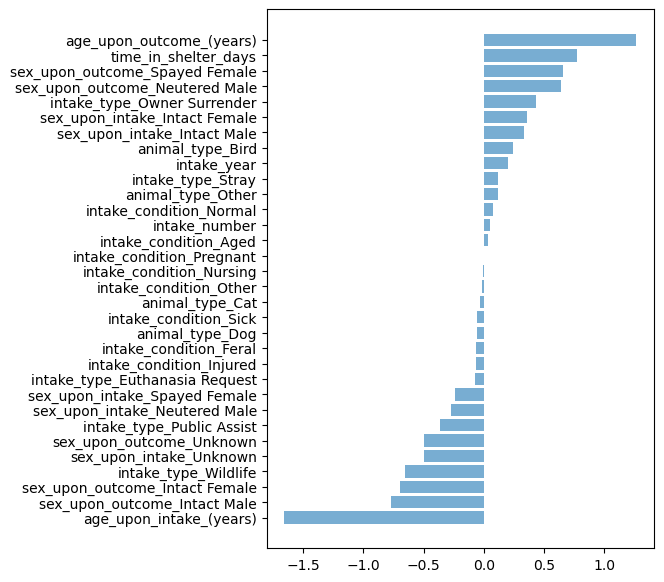

In [ ]:
tmp = []
for name, value in zip(train_features_std.columns, logistic.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")

plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)

revois les formules qui entrent en jeu dans leq questions ci-dessous


## Question 1: Which of the following metrics is most suitable when you are dealing with unbalanced classes?

- a) F1 Score
- b) Recall
- c) Precision
- d) Accuracy

a

## Question 2: You are working on a binary classification problem. You trained a model on a training dataset and got the following confusion matrix on the test dataset. What is true about the evaluation metrics (rounded to the second decimal point):

|            | Pred = NO|Pred=YES|
|------------|----------|--------|
| Actual NO  |    50    |   10   |
| Actual YES |    5     |   100  |

- a) Accuracy is 0.95
- b) Accuracy is 0.85
- c) False positive rate is 0.95
- d) True positive rate is 0.95

d